# Requirements

In [2]:
import pandas as pd 
import wandb

def load_metrics_from_wandb(proj_name):
    api = wandb.Api()
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    AUC_score = []
    accuracy = []

    for run in runs_df["summary"]:
        AUC_score.append(run["test_score"])
        accuracy.append(run["test_accuracy"])
    
    return AUC_score, accuracy

def load_MILC_metrics_from_wandb(proj_name):
    # I named test logs as train, so this is a lazy fix
    api = wandb.Api()
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    AUC_score = []
    accuracy = []

    for run in runs_df["summary"]:
        AUC_score.append(run["train_score"])
        accuracy.append(run["train_accuracy"])
    
    return AUC_score, accuracy

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# sns.set(font_scale = 2)
# sns.set(rc={'figure.figsize':(18,9)})
# так масштаб приятнее
sns.set_theme(style="whitegrid", font_scale = 3, rc={'figure.figsize':(18,9)})

sns.set_theme(
    style="whitegrid", 
    font_scale = 3, 
    rc={'figure.figsize':(18,9)}
)

def plot_box_plots(data, data_names, title, y_title):
    plot = sns.boxplot(
        data=data,
        showfliers = True,
    )
    plt.title(title)
    plot.set_xticklabels(data_names)
    plot.set(ylabel=y_title)

# Examples

## Import data from WandB

In [23]:
# project name: experiment-mlp-ukb
mlp_ukb_AUC, mlp_ukb_accuracy = load_metrics_from_wandb("experiment-mlp-ukb")

## Import data from CSV

In [ ]:
import csv
mlp_ukb_AUC = []
mlp_ukb_accyracy = []
with open('/path_to_csv.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        mlp_ukb_AUC.append(float(row[N]))
        mlp_ukb_accuracy.append(float(row[M]))

## Plot data

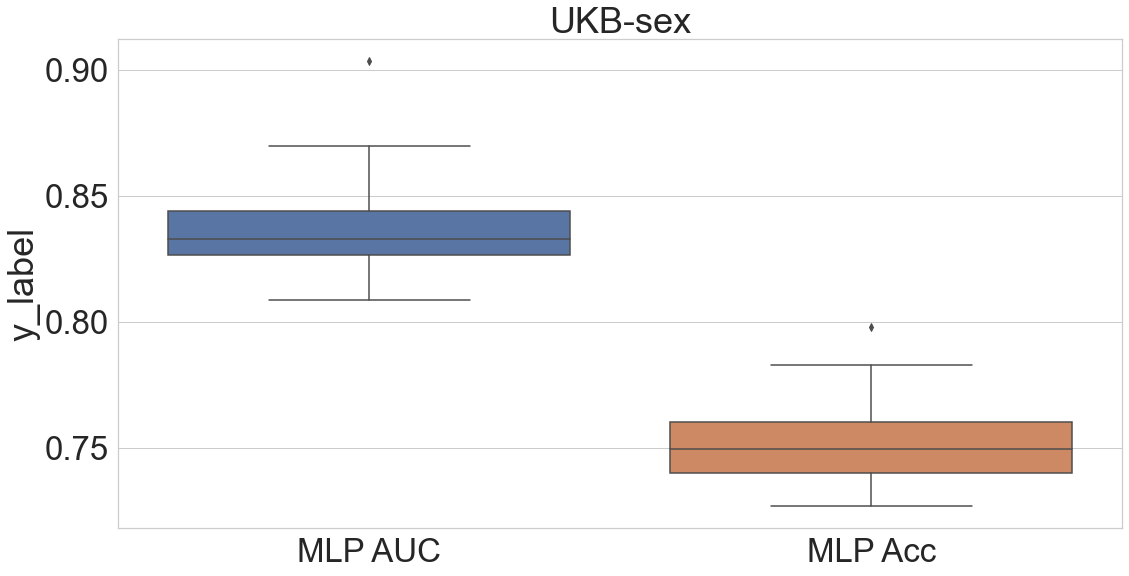

In [37]:
data = [mlp_ukb_AUC, mlp_ukb_accuracy]
data_names = ["MLP AUC", "MLP Acc"]
plot_box_plots(data, data_names, "UKB-sex", "y_label")


# Testing different MLP models on FBIRN

## MLP architectures

In [39]:
# MLP

mlp_fbirn_AUC, mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-mlp-fbirn")

# No Residual block MLP

nores_mlp_fbirn_AUC, nores_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-nores_mlp-fbirn")

# Transposed MLP

trans_mlp_fbirn_AUC, trans_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-trans_mlp-fbirn")

# no ensemble MLP

noens_mlp_fbirn_AUC, noens_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-noens_mlp-fbirn")

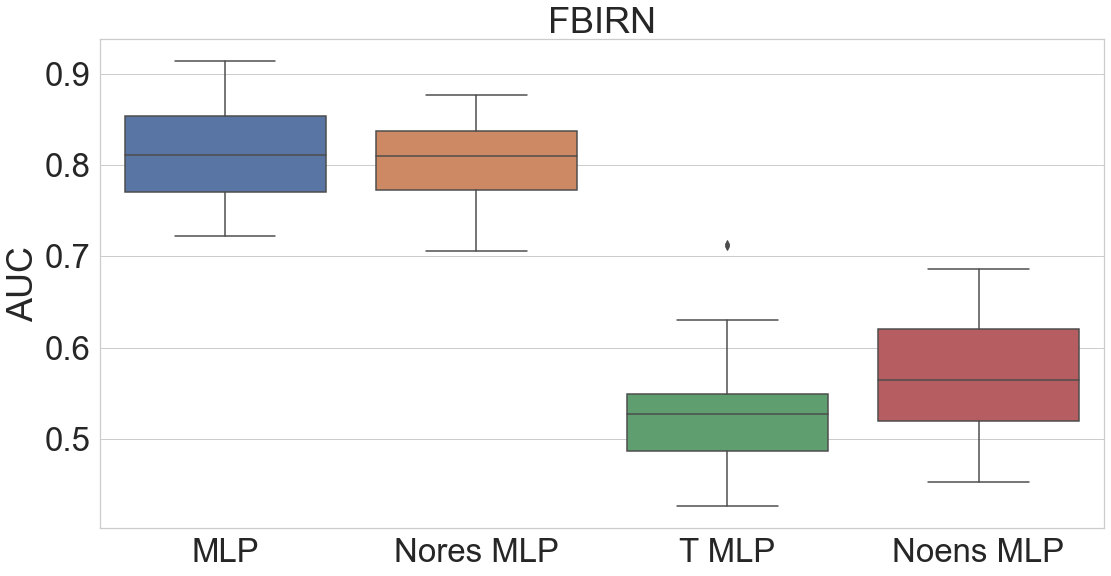

In [42]:
auc_data = [mlp_fbirn_AUC, nores_mlp_fbirn_AUC, trans_mlp_fbirn_AUC, noens_mlp_fbirn_AUC]
data_names = ["MLP", "Nores MLP", "T MLP", "Noens MLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "AUC")

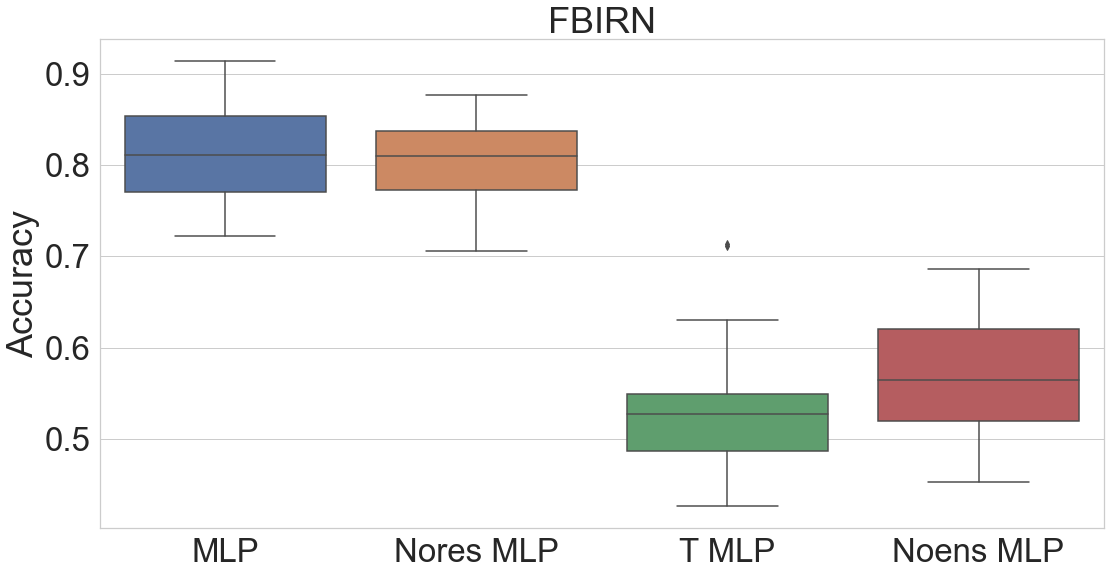

In [43]:
acc_data = [mlp_fbirn_accuracy, nores_mlp_fbirn_accuracy, trans_mlp_fbirn_accuracy, noens_mlp_fbirn_accuracy]
data_names = ["MLP", "Nores MLP", "T MLP", "Noens MLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "Accuracy")

## Deep, wide and attention MLP

In [28]:
# Simple MLP

mlp_fbirn_AUC, mlp_fbirn_accuracy = load_metrics_from_wandb("220817.031422-experiment-mlp-fbirn")

# Deep MLP

deep_mlp_fbirn_AUC, deep_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.020923-experiment-deep_mlp-fbirn")

# Wide MLP

wide_mlp_fbirn_AUC, wide_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.000759-tune-wide_mlp-fbirn")

# old attention MLP

old_attn_mlp_fbirn_AUC, old_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.044951-experiment-attention_mlp-fbirn")

# new attention MLP

new_attn_mlp_fbirn_AUC, new_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.041043-experiment-new_attention_mlp-fbirn")

# newest attention MLP

newest_attn_mlp_fbirn_AUC, newest_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220820.010149-experiment-newest_attention_mlp-fbirn")

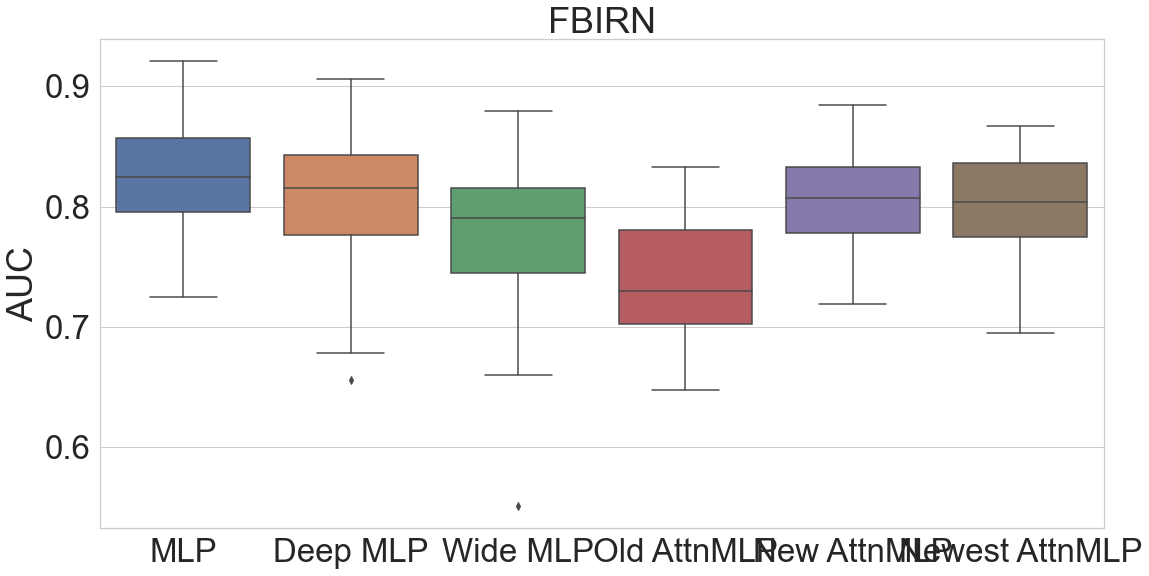

In [32]:
auc_data = [mlp_fbirn_AUC, deep_mlp_fbirn_AUC, wide_mlp_fbirn_AUC, old_attn_mlp_fbirn_AUC, new_attn_mlp_fbirn_AUC, newest_attn_mlp_fbirn_AUC]
data_names = ["MLP", "Deep MLP", "Wide MLP", "Old AttnMLP", "New AttnMLP", "Newest AttnMLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "AUC")

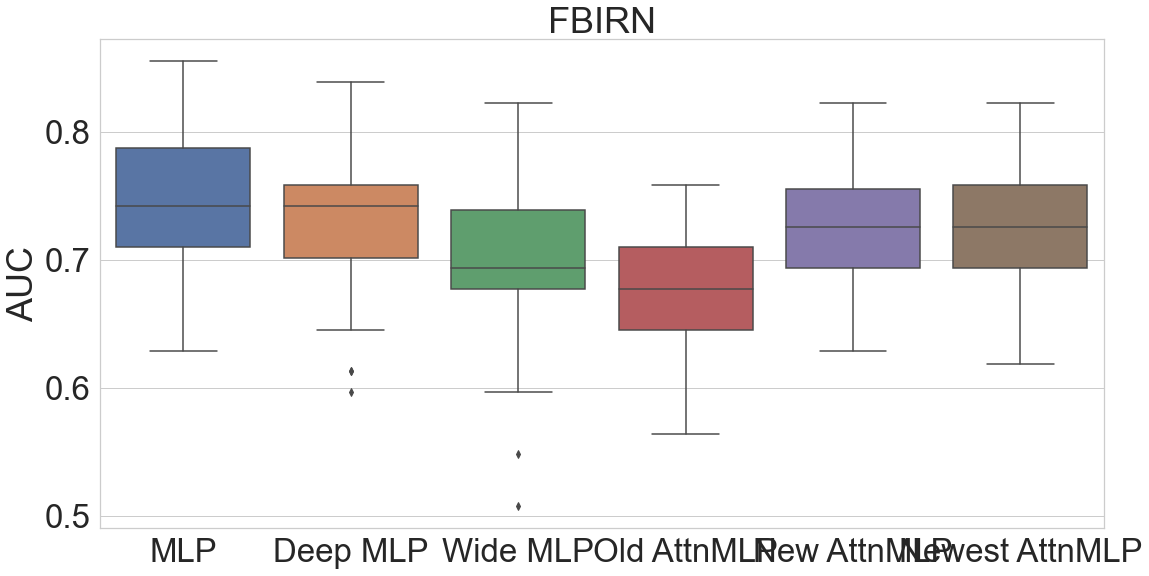

In [33]:
acc_data = [mlp_fbirn_accuracy, deep_mlp_fbirn_accuracy, wide_mlp_fbirn_accuracy, old_attn_mlp_fbirn_accuracy, new_attn_mlp_fbirn_accuracy, newest_attn_mlp_fbirn_accuracy]
data_names = ["MLP", "Deep MLP", "Wide MLP", "Old AttnMLP", "New AttnMLP", "Newest AttnMLP"]
plot_box_plots(acc_data, data_names, "FBIRN", "AUC")

# Experiments

## Oasis

In [7]:
mlp_oasis_auc, mlp_oasis_acc = load_metrics_from_wandb("220811.052827-experiment-mlp-oasis")
att_mlp_oasis_auc, att_mlp_oasis_acc = load_metrics_from_wandb("220817.022010-experiment-new_attention_mlp-oasis")
lstm_oasis_auc, lstm_oasis_acc = load_metrics_from_wandb("220817.085028-experiment-lstm-oasis")
milc_oasis_auc, milc_oasis_acc = load_MILC_metrics_from_wandb("new-experiment-milc-oasis")
# _oasis_auc, _oasis_acc = load_metrics_from_wandb("")
# _oasis_auc, _oasis_acc = load_metrics_from_wandb("")
# _oasis_auc, _oasis_acc = load_metrics_from_wandb("")
# _oasis_auc, _oasis_acc = load_metrics_from_wandb("")

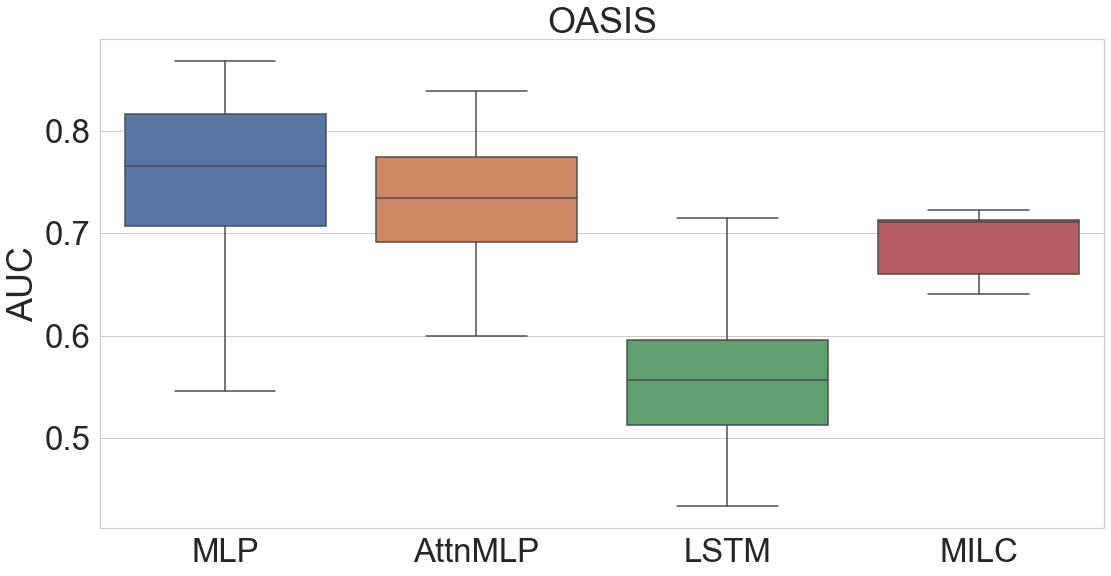

In [32]:
auc_data = [mlp_oasis_auc, att_mlp_oasis_auc, lstm_oasis_auc, milc_oasis_auc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(auc_data, data_names, "OASIS", "AUC")

plt.savefig(
    "./images/oasis_auc.png",
    format="png",
    dpi=300,
)

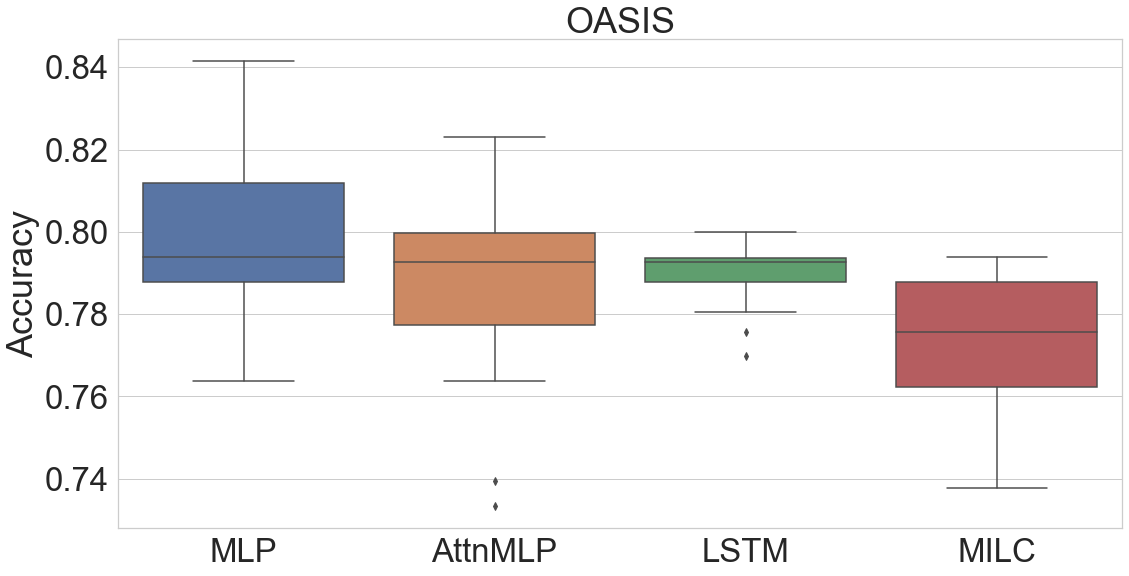

In [33]:
acc_data = [mlp_oasis_acc, att_mlp_oasis_acc, lstm_oasis_acc, milc_oasis_acc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(acc_data, data_names, "OASIS", "Accuracy")

plt.savefig(
    "./images/oasis_acc.png",
    format="png",
    dpi=300,
)

## Abide

In [5]:
mlp_abide_auc, mlp_abide_acc = load_metrics_from_wandb("220811.190848-experiment-mlp-abide")
att_mlp_abide_auc, att_mlp_abide_acc = load_metrics_from_wandb("220817.033648-experiment-new_attention_mlp-abide")
lstm_abide_auc, lstm_abide_acc = load_metrics_from_wandb("220817.131942-experiment-lstm-abide")
milc_abide_auc, milc_abide_acc = load_MILC_metrics_from_wandb("new-experiment-milc-abide")
# _abide_auc, _abide_acc = load_metrics_from_wandb("")
# _abide_auc, _abide_acc = load_metrics_from_wandb("")
# _abide_auc, _abide_acc = load_metrics_from_wandb("")
# _abide_auc, _abide_acc = load_metrics_from_wandb("")

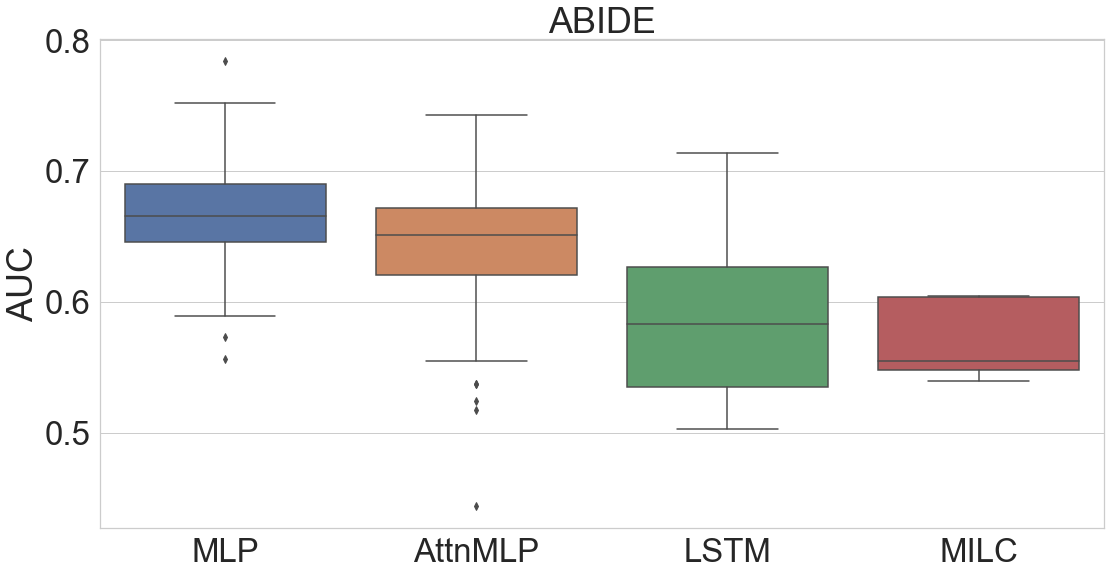

In [34]:
auc_data = [mlp_abide_auc, att_mlp_abide_auc, lstm_abide_auc, milc_abide_auc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(auc_data, data_names, "ABIDE", "AUC")

plt.savefig(
    "./images/abide_auc.png",
    format="png",
    dpi=300,
)

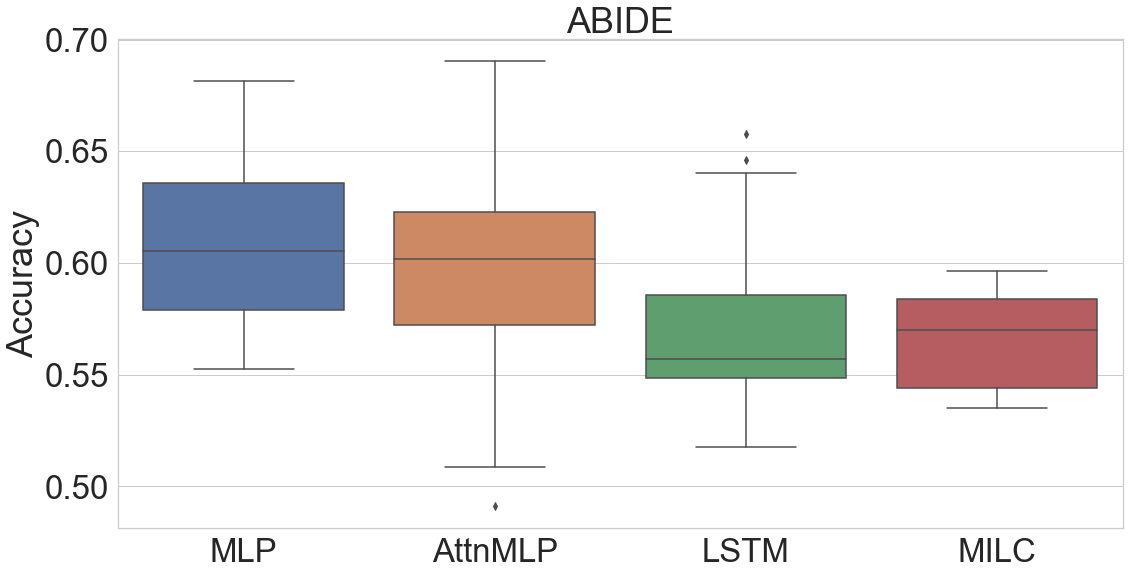

In [35]:
acc_data = [mlp_abide_acc, att_mlp_abide_acc, lstm_abide_acc, milc_abide_acc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(acc_data, data_names, "ABIDE", "Accuracy")

plt.savefig(
    "./images/abide_acc.png",
    format="png",
    dpi=300,
)

## FBIRN

In [7]:
mlp_fbirn_auc, mlp_fbirn_acc = load_metrics_from_wandb("220817.031422-experiment-mlp-fbirn")
att_mlp_fbirn_auc, att_mlp_fbirn_acc = load_metrics_from_wandb("220817.041043-experiment-new_attention_mlp-fbirn")
lstm_fbirn_auc, lstm_fbirn_acc = load_metrics_from_wandb("220817.225007-experiment-lstm-fbirn")
milc_fbirn_auc, milc_fbirn_acc = load_MILC_metrics_from_wandb("new-experiment-milc-fbirn")
# _fbirn_auc, _fbirn_acc = load_metrics_from_wandb("")
# _fbirn_auc, _fbirn_acc = load_metrics_from_wandb("")
# _fbirn_auc, _fbirn_acc = load_metrics_from_wandb("")


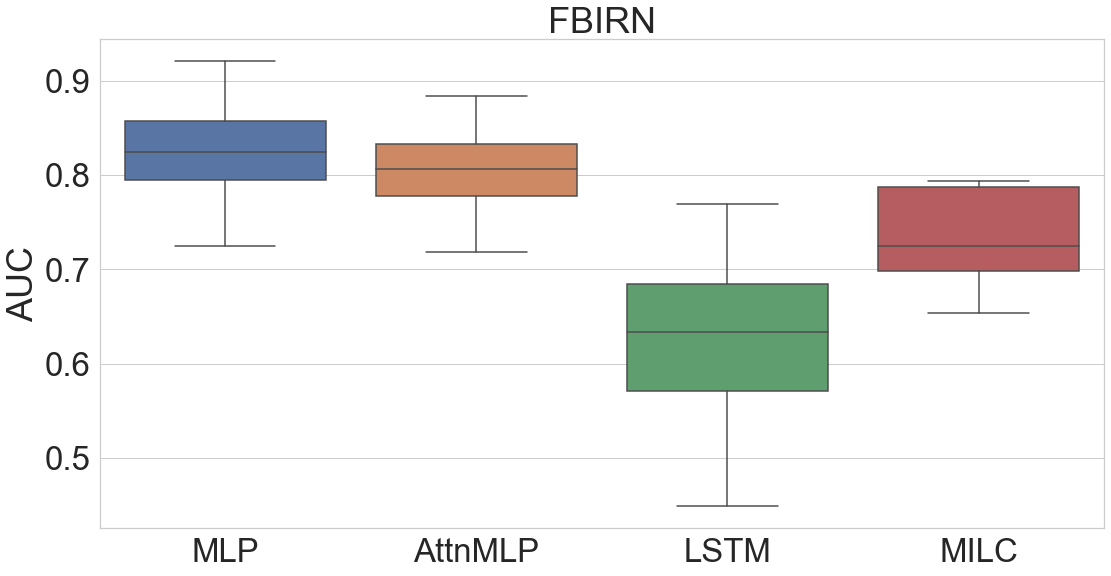

In [36]:
auc_data = [mlp_fbirn_auc, att_mlp_fbirn_auc, lstm_fbirn_auc, milc_fbirn_auc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(auc_data, data_names, "FBIRN", "AUC")

plt.savefig(
    "./images/fbirn_auc.png",
    format="png",
    dpi=300,
)

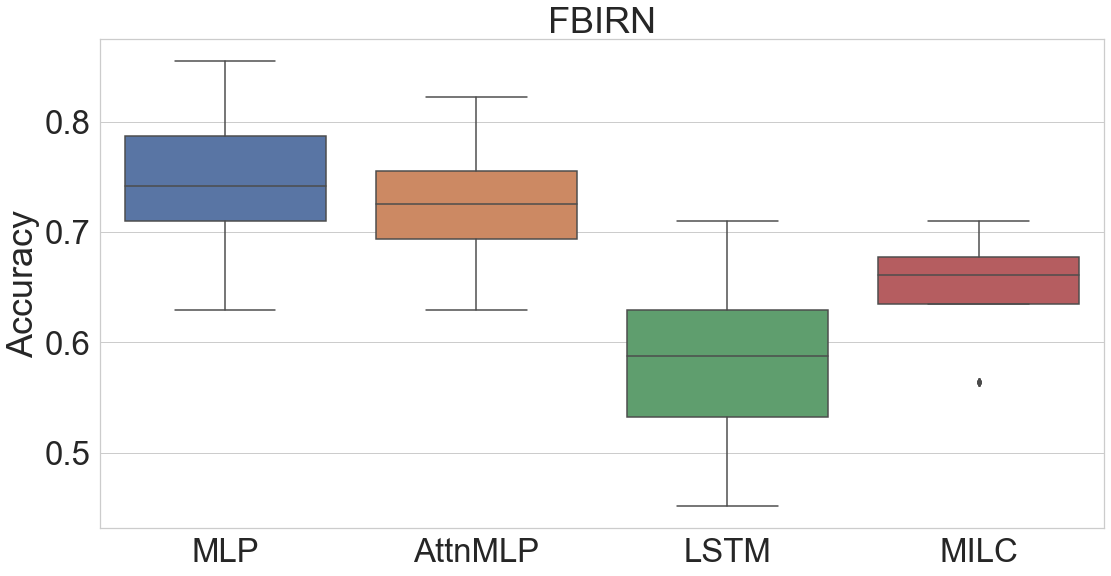

In [37]:
acc_data = [mlp_fbirn_acc, att_mlp_fbirn_acc, lstm_fbirn_acc, milc_fbirn_acc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(acc_data, data_names, "FBIRN", "Accuracy")

plt.savefig(
    "./images/fbirn_acc.png",
    format="png",
    dpi=300,
)

## Abide 869

In [16]:
mlp_abide_869_auc, mlp_abide_869_acc = load_metrics_from_wandb("220811.221744-experiment-mlp-abide_869")
att_mlp_abide_869_auc, att_mlp_abide_869_acc = load_metrics_from_wandb("220817.052433-experiment-new_attention_mlp-abide_869")
lstm_abide_869_auc, lstm_abide_869_acc = load_metrics_from_wandb("220820.205431-experiment-lstm-abide_869")
milc_abide_869_auc, milc_abide_869_acc = load_MILC_metrics_from_wandb("new-experiment-milc-abide_869")
# _abide_869_auc, _abide_869_acc = load_metrics_from_wandb("")
# _abide_869_auc, _abide_869_acc = load_metrics_from_wandb("")
# _abide_869_auc, _abide_869_acc = load_metrics_from_wandb("")


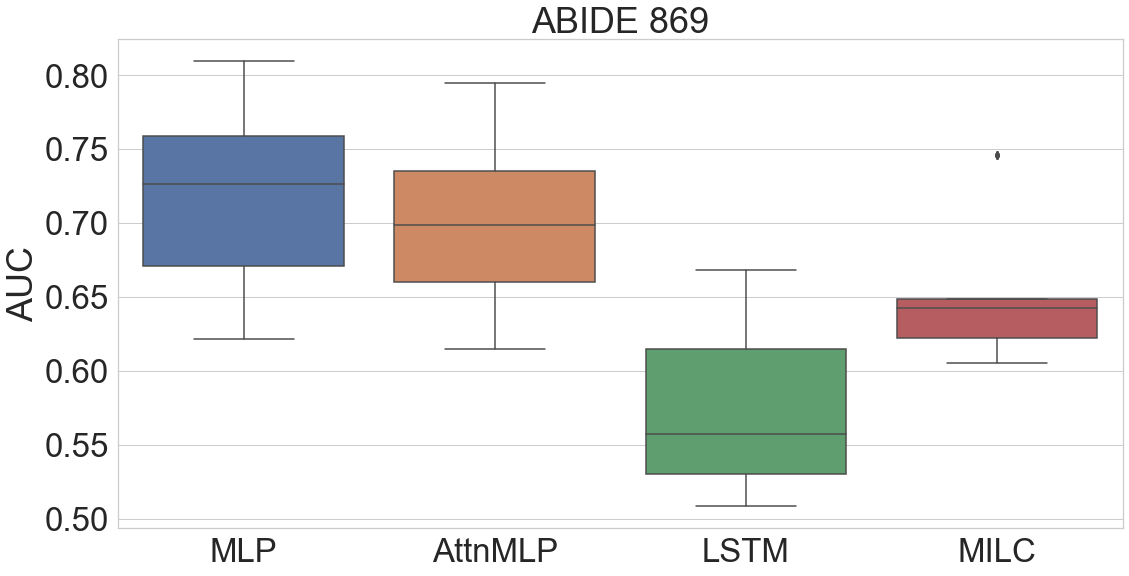

In [17]:
auc_data = [mlp_abide_869_auc, att_mlp_abide_869_auc, lstm_abide_869_auc, milc_abide_869_auc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(auc_data, data_names, "ABIDE 869", "AUC")

plt.savefig(
    "./images/abide_869_auc.png",
    format="png",
    dpi=300,
)

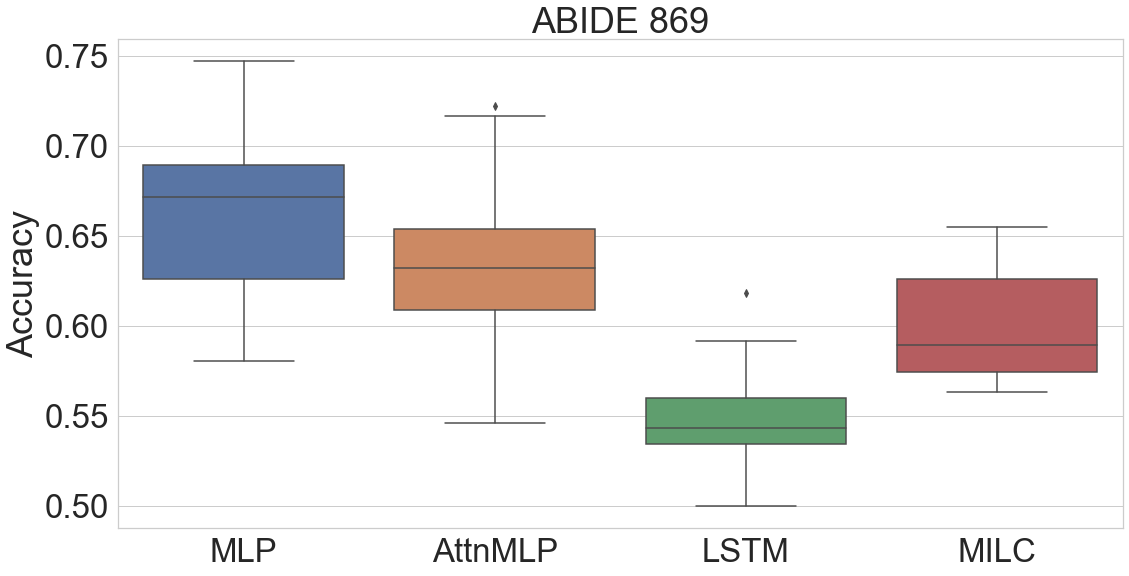

In [18]:
acc_data = [mlp_abide_869_acc, att_mlp_abide_869_acc, lstm_abide_869_acc, milc_abide_869_acc]
data_names = ["MLP", "AttnMLP", "LSTM", "MILC"]
plot_box_plots(acc_data, data_names, "ABIDE 869", "Accuracy")

plt.savefig(
    "./images/abide_869_acc.png",
    format="png",
    dpi=300,
)

# Tests

In [15]:
# BSNIP and cross datasets
mlp_fbirn_auc, mlp_fbirn_acc = load_metrics_from_wandb("220817.031422-experiment-mlp-fbirn")
mlp_bsnip_auc, mlp_bsnip_acc = load_metrics_from_wandb("220825.233315-experiment-mlp-bsnip")
mlp_cobre_auc, mlp_cobre_acc = load_metrics_from_wandb("220826.151424-experiment-mlp-cobre")

mlp_fbirn_cobre_auc, mlp_fbirn_cobre_acc = load_metrics_from_wandb("220826.142839-experiment-mlp-fbrin_cobre")
mlp_fbirn_bsnip_auc, mlp_fbirn_bsnip_acc = load_metrics_from_wandb("220826.044924-experiment-mlp-fbrin_bsnip")

mlp_bsnip_cobre_auc, mlp_bsnip_cobre_acc = load_metrics_from_wandb("220826.051757-experiment-mlp-bsnip_cobre")
mlp_bsnip_fbirn_auc, mlp_bsnip_fbirn_acc = load_metrics_from_wandb("220826.173300-experiment-mlp-bsnip_fbirn")

mlp_cobre_bsnip_auc, mlp_cobre_bsnip_acc = load_metrics_from_wandb("220826.191435-experiment-mlp-cobre_bsnip")
mlp_cobre_fbirn_auc, mlp_cobre_fbirn_acc = load_metrics_from_wandb("220826.175317-experiment-mlp-cobre_fbirn")

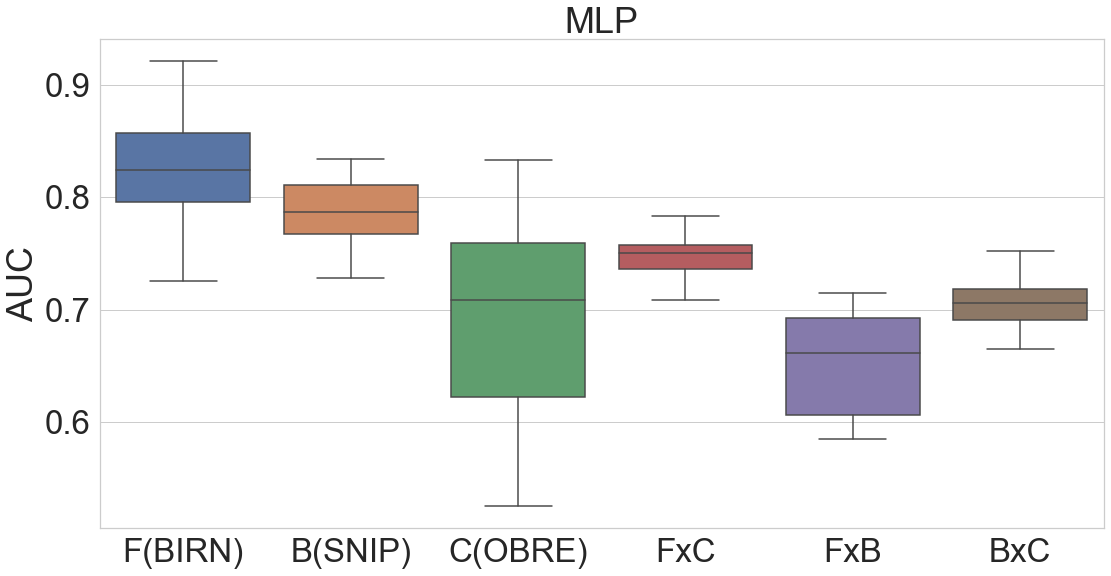

In [21]:
acc_data = [mlp_fbirn_auc, mlp_bsnip_auc, mlp_cobre_auc, mlp_fbirn_cobre_auc, mlp_fbirn_bsnip_auc, mlp_bsnip_cobre_auc]
data_names = ["F(BIRN)", "B(SNIP)", "C(OBRE)", "FxC", "FxB", "BxC"]
plot_box_plots(acc_data, data_names, "MLP", "AUC")


plt.show()
# plt.savefig(
#     "./images/abide_869_acc.png",
#     format="png",
#     dpi=300,
# )